# Data Cleansing

In [64]:
# importing all necessary libraries

# pip install -r requirements.txt

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from datetime import datetime, timedelta
import statsmodels.api as sm
import gc
from pylab import rcParams
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import gc
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import lightgbm as lgb
import calendar
import signal
import scipy

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import multiprocessing as mp
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Load data

In [65]:
# Reading datasets

train = pd.read_csv('input/train.csv')

# Date format

train['date'] = pd.to_datetime(train['date'])
train['product_number'] = train['product_number'].astype(str)
train['reporterhq_id'] = train['reporterhq_id'].astype(str)
train['sku'] = train['reporterhq_id']+train['product_number']

# Check

print("Head rows of train data")
train.head()

Head rows of train data


,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,sales_units,inventory_units,sku
0,202224-2961,2022-06-18,202224,2961,15,Doraemon,186631,15.6,Gaming,52.0,88.0,152961
1,202225-2961,2022-06-25,202225,2961,15,Doraemon,186631,15.6,Gaming,6.0,88.0,152961
2,202226-2961,2022-07-02,202226,2961,15,Doraemon,186631,15.6,Gaming,60.0,138.0,152961
3,202227-2961,2022-07-09,202227,2961,15,Doraemon,186631,15.6,Gaming,158.0,65.0,152961
4,202228-2961,2022-07-16,202228,2961,15,Doraemon,186631,15.6,Gaming,23.0,30.0,152961


# Data Cleansing

In [66]:
# Formatting

train["product_number"] = train["product_number"].astype(str)
train = train[["id", "date", "product_number", "reporterhq_id", "prod_category", "segment", "sales_units", "inventory_units", "sku"]]
train.head()

,id,date,product_number,reporterhq_id,prod_category,segment,sales_units,inventory_units,sku
0,202224-2961,2022-06-18,2961,15,Doraemon,Gaming,52.0,88.0,152961
1,202225-2961,2022-06-25,2961,15,Doraemon,Gaming,6.0,88.0,152961
2,202226-2961,2022-07-02,2961,15,Doraemon,Gaming,60.0,138.0,152961
3,202227-2961,2022-07-09,2961,15,Doraemon,Gaming,158.0,65.0,152961
4,202228-2961,2022-07-16,2961,15,Doraemon,Gaming,23.0,30.0,152961


In [67]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25139 entries, 0 to 25138
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               25139 non-null  object        
 1   date             25139 non-null  datetime64[ns]
 2   product_number   25139 non-null  object        
 3   reporterhq_id    25139 non-null  object        
 4   prod_category    25139 non-null  object        
 5   segment          25139 non-null  object        
 6   sales_units      24642 non-null  float64       
 7   inventory_units  24639 non-null  float64       
 8   sku              25139 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 1.7+ MB
None


## Duplicates

In [68]:
# Deal with duplicates

# Group by date and calculate the average of inventory and sales

train_grouped = train.groupby(['id', 'date', 'product_number', 'reporterhq_id', 'prod_category', 'segment', 'sku']).agg({'inventory_units': 'mean', 'sales_units': 'mean'}).reset_index()

train_grouped.head()

,id,date,product_number,reporterhq_id,prod_category,segment,sku,inventory_units,sales_units
0,201915-233919,2019-04-13,233919,3,Clover,Core,3233919,20.0,2.0
1,201916-233919,2019-04-20,233919,3,Clover,Core,3233919,43.0,4.0
2,201917-233919,2019-04-27,233919,24,Clover,Core,24233919,110.0,1.0
3,201917-233919,2019-04-27,233919,3,Clover,Core,3233919,74.0,121.0
4,201918-233919,2019-05-04,233919,24,Clover,Core,24233919,120.0,12.0


In [69]:
# Set Forecasting level

train_grouped = train.groupby(['date', 'id', 'product_number', 'reporterhq_id', 'prod_category', 'segment', 'sku']).agg({'inventory_units': 'sum', 'sales_units': 'sum'}).reset_index()

train_grouped.head()

,date,id,product_number,reporterhq_id,prod_category,segment,sku,inventory_units,sales_units
0,2019-04-13,201915-233919,233919,3,Clover,Core,3233919,20.0,2.0
1,2019-04-20,201916-233919,233919,3,Clover,Core,3233919,43.0,4.0
2,2019-04-27,201917-233919,233919,24,Clover,Core,24233919,110.0,1.0
3,2019-04-27,201917-233919,233919,3,Clover,Core,3233919,74.0,121.0
4,2019-05-04,201918-233919,233919,24,Clover,Core,24233919,120.0,12.0


In [70]:
# Auxiliar function for missing dates

# fill_missing_dates()

def fill_missing_dates(group):
    
    # Set the 'date' column as the index
    
    group = group.set_index('date')

    # Create a date range covering the full scope of dates
    
    full_date_range = pd.date_range(start=group.index.min(), end=group.index.max(), freq='7D')

    # Reindex the group to include the full date range and fill missing dates with previous value
    
    reindexed_group = group.reindex(full_date_range).ffill()

    # Reset the index and forward-fill missing values within the group
    
    reindexed_group.index = reindexed_group.index.set_names(['date'])
    
    reindexed_group = reindexed_group.reset_index(drop = False)
    
    return reindexed_group

## Check if data is complete

In [71]:
# Sort by sku & date

train_index = train_grouped.sort_values(['id'])

# Apply fill missing dates

train_filled = train_index.groupby('sku').apply(fill_missing_dates)

# Reset the index

train_filled = train_filled.reset_index(drop=True)

# train_filled.head()

## Outliers function

In [72]:
# Auxiliar function

# detect_outliers()

# https://es.wikipedia.org/wiki/Filtro_de_Savitzky%E2%80%93Golay
# https://www.datatechnotes.com/2022/05/smoothing-example-with-savitzky-golay.html
# Savitzky filter: Local polinomial regression

def detect_outliers(group):
    
    # Detrend the inventory and sales values using a signal processing method 
    
    # (e.g., Savitzky-Golay filter)
    
    if len(group) > 2:
        
        # Calculate the appropriate window length based on the weekly frequency
        
        window_length = min(len(group), 5)  # Adjust the window length as desired
        window_length = window_length if window_length % 2 == 1 else window_length - 1  # Make window_length odd
        
        polyorder = min(window_length - 1, 3)
        
        group['inventory_detrended'] = scipy.signal.savgol_filter(group['inventory_units'], window_length = window_length, polyorder = polyorder, deriv = 0)
        group['sales_detrended'] = scipy.signal.savgol_filter(group['sales_units'], window_length = window_length, polyorder = polyorder, deriv = 0)
        
    else:
        
        group['inventory_detrended'] = group['inventory_units']
        group['sales_detrended'] = group['sales_units']

    # Calculate residuals by subtracting the detrended values from the original values
    
    group['inventory_residuals'] = group['inventory_units'] - group['inventory_detrended']
    group['sales_residuals'] = group['sales_units'] - group['sales_detrended']

    # Calculate z-scores for the residuals
    
    z_scores_inventory = (group['inventory_residuals'] - group['inventory_residuals'].mean()) / group['inventory_residuals'].std()
    z_scores_sales = (group['sales_residuals'] - group['sales_residuals'].mean()) / group['sales_residuals'].std()

    # Set a threshold for z-scores to identify outliers (e.g., 3 standard deviations)
    
    outlier_threshold = 3
    outliers_inventory = np.abs(z_scores_inventory) > outlier_threshold
    outliers_sales = np.abs(z_scores_sales) > outlier_threshold

    # Fill outliers with the average of previous observations (3) based on date for the same product
    
    # Using mask
    
    group['inventory_units_cleansed'] = group['inventory_units'].mask(outliers_inventory, group['inventory_units'].shift().rolling(window = 3, min_periods=1).mean())
    group['sales_units_cleansed'] = group['sales_units'].mask(outliers_sales, group['sales_units'].shift().rolling(window = 3, min_periods=1).mean())

    return group

## Apply Cleansing

In [73]:
# Cleansing | winsorize

train_cleansed_tmp = train_filled

# Apply outlier detection and detrending for each SKU group

train_cleansed_tmp = train_cleansed_tmp.groupby('product_number').apply(detect_outliers)

# Drop NA in case still exist

train_cleansed_tmp = train_cleansed_tmp.dropna(subset=['inventory_units', 'sales_units'])

# Reset the index if needed

train_cleansed = train_cleansed_tmp.reset_index(drop=True)

# train_cleansed.head()

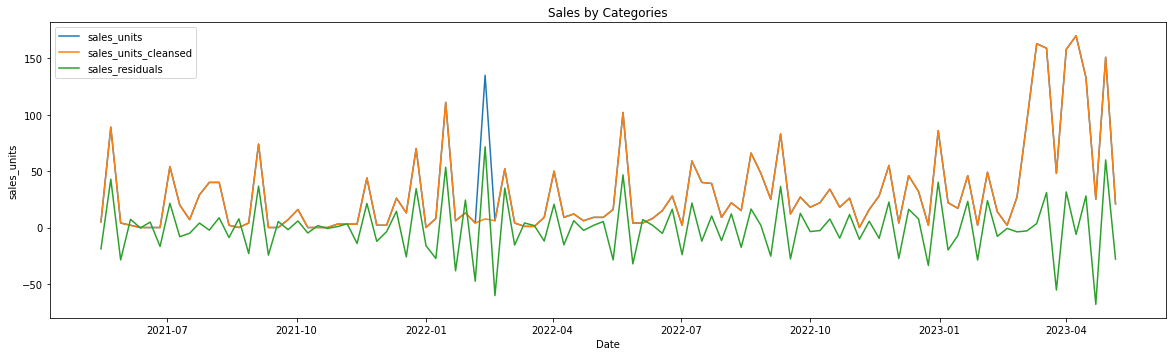

In [78]:
# Plot

# Check 105609

train_cleansed_plot = train_cleansed[train_cleansed['product_number'] == "105609"]
# train_cleansed_plot = train_cleansed

# Plot

train_cleansed_plot = train_cleansed_plot.groupby(['date','product_number']).sum()
train_cleansed_plot = train_cleansed_plot.reset_index()
plt.figure(figsize=(20,25))
plt.subplot(411)
plt.plot(train_cleansed_plot['date'].values, train_cleansed_plot['sales_units'].values, label="sales_units")
plt.plot(train_cleansed_plot['date'].values, train_cleansed_plot['sales_units_cleansed'].values, label="sales_units_cleansed")
# plt.plot(train_cleansed_plot['date'].values, train_cleansed_plot['sales_detrended'].values, label="sales_detrended")
plt.plot(train_cleansed_plot['date'].values, train_cleansed_plot['sales_residuals'].values, label="sales_residuals")
plt.xlabel('Date')
plt.ylabel('sales_units')
plt.title("Sales by Categories")
plt.legend()
plt.show()

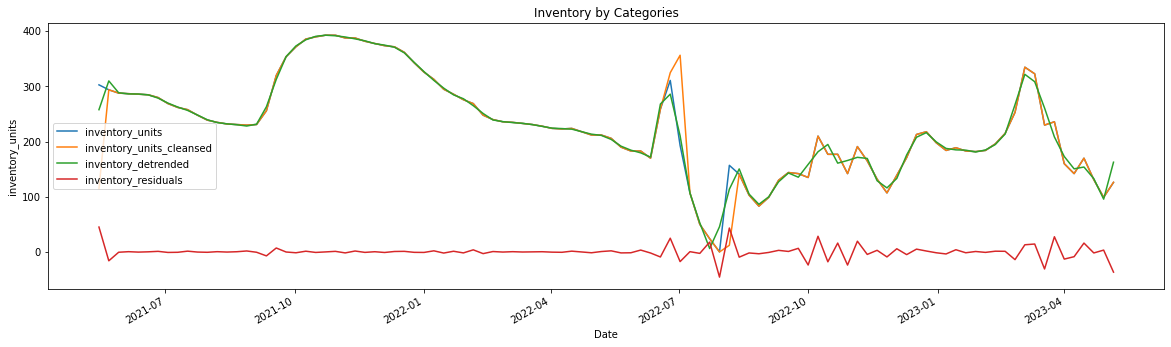

In [77]:
# Plot Inventory

# Check 105609
 
train_cleansed_plot = train_cleansed[train_cleansed['product_number'] == "105609"]
# train_cleansed_plot = train_cleansed

# Plot

train_cleansed_plot = train_cleansed_plot.groupby(['date','product_number']).sum()
train_cleansed_plot = train_cleansed_plot.reset_index()
plt.figure(figsize=(20,25))
plt.subplot(411)
plt.plot(train_cleansed_plot['date'].values, train_cleansed_plot['inventory_units'].values,label="inventory_units")
plt.plot(train_cleansed_plot['date'].values, train_cleansed_plot['inventory_units_cleansed'].values,label="inventory_units_cleansed")
plt.plot(train_cleansed_plot['date'].values, train_cleansed_plot['inventory_detrended'].values,label="inventory_detrended")
plt.plot(train_cleansed_plot['date'].values, train_cleansed_plot['inventory_residuals'].values,label="inventory_residuals")
plt.xlabel('Date')
plt.ylabel('inventory_units')
plt.title("Inventory by Categories")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

## Write output

In [76]:
# Drop sku and write

train_cleansed = train_cleansed.drop(['sku'], axis = 1)
train_cleansed.to_csv('input/train_cleansed.csv', index = False)

# Done